# **Transfer Learning with ResNet50**

## **Problem Statement**

Classify the images of cats and dogs in a dataset using ResNet50.

### **Objective**

Perform Transfer Learning using the ResNet50 pre-trained weights

The resnet50 folder has 2 pre-trained weights files:
* xyz_tf_kernels.h5: It is useful for pure prediction of test image and this prediction will rely completely on ResNet50 pre-trained weights, i.e., it does not expected any training from our side.
<br>

* xyz_tf_kernels_NOTOP.h5: It is a top layer weight that is used as initial weight for training new layer using train images.
 

### **Import the Dependencies**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, cv2, random
from tqdm import tqdm
from random import shuffle

%matplotlib inline

In [2]:
# !pip install opencv-python

In [3]:
# path = os.getcwd()
# path

### **Define constant values**

In [4]:
# TRAIN_DIR = 'Path of train dataset'
# TEST_DIR = 'Path of test dataset'
TRAIN_DIR = './train'
TEST_DIR = './test'
NUM_CLASSES = 2
IMG_SIZE = 224
EPOCHS = 20

train_images = os.listdir(TRAIN_DIR)#For testing 
test_images = os.listdir(TEST_DIR)

In [15]:
test_images

[]

### **Generate Arrays**

In [5]:
# Get an array [cat, dog] of image
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog' : return [0, 1]

# Get a numpy array of test and train data
def create_train_data():
    training_data = []
    for img in tqdm(train_images):
        label = label_img(img)
        img_path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(img_path, cv2.IMREAD_ANYCOLOR)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data

def process_test_data():
    testing_data = []
    for img in tqdm(test_images):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    shuffle(testing_data)
    return testing_data

training_data = create_train_data()
X = np.array([i[0] for i in training_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in training_data])

0it [00:00, ?it/s]


### **Import the Libraries**

In [11]:
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras.layers import Dense

### **Define the Path and Create the Model**

In [12]:
# Path of ResNet50 pre-trained weights except its TOP layer,
# RESNET_WEIGHTS_PATH = 'Path of resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
RESNET_WEIGHTS_PATH = './resnet_weights'

model = Sequential()
model.add(ResNet50(include_top = False,
                   pooling = 'max',
                   weights = "imagenet"))
model.add(Dense(NUM_CLASSES, activation= 'softmax'))
model.layers[0].trainable = False

# Compile the Transfer Learning Model
sgd = optimizers.SGD(lr = 1e-3, decay = 1e-6, momentum = 0.1, nesterov=True)
model.compile(optimizer= sgd, loss = 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_3 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


C:\Users\Hp\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### **Train the Model**

In [13]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
check_point = ModelCheckpoint('BestModel.hdf5', verbose=True, save_best_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=3, verbose=1)
history = model.fit(X, y,
                    validation_split=0.2,
                    callbacks = [check_point, lr_reduce],
                    epochs=EPOCHS,
                    batch_size=80,
                    verbose=1)

ValueError: Training data contains 0 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.2`. Either provide more data, or a different value for the `validation_split` argument.

### **Plot the Model and Summarize the Loss**

In [0]:
# Plotting loss and accuracy for the model
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Test the Model**

In [0]:
# Making space
import gc
del X, y, training_data
gc.collect()

# Loading the best model
from keras.models import load_model
model = load_model('BestModel.hdf5')

# Testing the model on test dataset
test_data = process_test_data()
fig =plt.figure()
for num, data in enumerate(test_data[:12]):
    # Cat: [1, 0]
    # Dog: [0, 1]
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    data = img_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1 : str_label ='Dog'
    else: str_label = 'Cat'
    y.imshow(img_data)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False);
    y.axes.get_yaxis().set_visible(False);
plt.show()

### **Obtain the Result**

In [0]:
prob = []
img_list = []
for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(-1,IMG_SIZE,IMG_SIZE,3)
        model_out = model.predict([data])[0]
        img_list.append(img_num)
        prob.append(model_out[1])
    
result = pd.DataFrame({'id':img_list , 'label':prob})
print(result.head())

          hours
activity       
Work          8
Sleep        10
Play          6


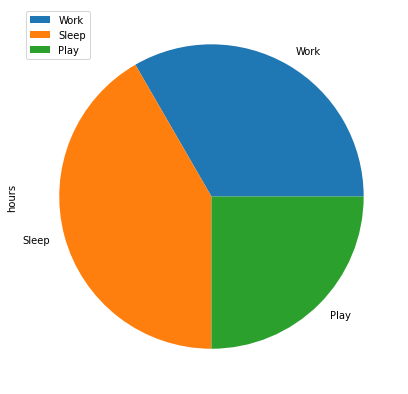

In [12]:
import pandas as pd

df = pd.DataFrame({'activity': ['Work', 'Sleep', 'Play'],
                   'hours': [8, 10, 6]})
df.set_index('activity', inplace=True)
print(df)
#               hours
# activity       
# Work          8
# Sleep        10
# Play          6
plot = df.plot.pie(y='hours', figsize=(7, 7))